# **Tech Challenge Fase II**

**Introdução**:
Foi nos dada a missão de criar um modelo preditivo com dados da Bolsa de Valores Brasileira, onde devemos perver o fechamento diário.

**Premissas**:

*   Indicação do melhor modelo;
*   Explicação da técnica utilizada;
*   O modelo deve ter assertividade >70%;



# **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb
import statsmodels.api as sm
from matplotlib.dates import DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller as adf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

# **Import and Discovery the DataFrame**

Período: 2020 à 2024

In [ ]:
df = pd.read_csv('/content/Dados Históricos - Ibovespa.csv', sep=';')
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,27/12/2000,15.186,14.805,15.223,14.805,"239,98M","2,65%"
1,28/12/2000,15.259,15.188,15.269,15.132,"324,26M","0,48%"
2,02/01/2001,15.425,15.242,15.621,15.174,"230,63M","1,09%"
3,03/01/2001,16.599,15.425,16.599,15.251,"381,20M","7,61%"
4,04/01/2001,16.675,16.597,16.933,16.587,"331,23M","0,46%"


In [ ]:
# VALIDATING DATAFRAME
df.tail()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
5734,23/02/2024,129.419,130.240,130.624,129.077,"9,23M","-0,63%"
5735,26/02/2024,129.609,129.417,129.978,129.077,"7,44M","0,15%"
5736,27/02/2024,131.689,129.613,131.696,129.613,"10,05M","1,61%"
5737,28/02/2024,130.155,131.685,131.685,129.771,"9,05M","-1,16%"
5738,29/02/2024,129.020,130.155,130.155,128.669,"12,00M","-0,87%"


In [ ]:
#VALIDATING LINES AND COLUMNS
df.shape

(5739, 7)

In [ ]:
# VALIDATING STRUCTURE DATAFRAME

# Aqui já é possível observar que algumas colunas precisam de tratamento.
# DATA
# VOL.
# VAR%

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5739 entries, 0 to 5738
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      5739 non-null   object 
 1   Último    5739 non-null   float64
 2   Abertura  5739 non-null   float64
 3   Máxima    5739 non-null   float64
 4   Mínima    5739 non-null   float64
 5   Vol.      5738 non-null   object 
 6   Var%      5739 non-null   object 
dtypes: float64(4), object(3)
memory usage: 314.0+ KB


In [ ]:
# ANALISYS VARIATION
df.describe().round()

,Último,Abertura,Máxima,Mínima
count,5739.0,5739.0,5739.0,5739.0
mean,60.0,60.0,61.0,60.0
std,32.0,32.0,32.0,32.0
min,8.0,8.0,9.0,8.0
25%,38.0,38.0,38.0,37.0
50%,57.0,57.0,58.0,56.0
75%,78.0,78.0,79.0,77.0
max,134.0,134.0,134.0,134.0


In [ ]:
# ANALISYS VARIATION
df.describe().round()

,Último,Abertura,Máxima,Mínima
count,5739.0,5739.0,5739.0,5739.0
mean,60.0,60.0,61.0,60.0
std,32.0,32.0,32.0,32.0
min,8.0,8.0,9.0,8.0
25%,38.0,38.0,38.0,37.0
50%,57.0,57.0,58.0,56.0
75%,78.0,78.0,79.0,77.0
max,134.0,134.0,134.0,134.0


In [ ]:
#DUPLICATED VALUES
df.duplicated().sum()

0

In [ ]:
#NULL VALUES
df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [ ]:
#SHOW ONLY NULL LINES

line_null = df[df.isnull().any(axis=1)]
print(line_null)

            Data  Último  Abertura  Máxima  Mínima Vol.    Var%
3740  10/02/2016  40.377    40.592  40.592   39.96  NaN  -0,53%


In [ ]:
df.fillna(df.mean(), inplace=True)

<ipython-input-16-bf934754a5b1>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.fillna(df.mean(), inplace=True)


In [ ]:
#TRATANDO A COLUNA VARIAÇÃO
df['Var%'] = pd.to_numeric(df['Var%'].apply(lambda x: x.split('%')[0].replace(',', '.')))
##df.drop(columns=['Var%'], axis=1, inplace=True)
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,27/12/2000,15.186,14.805,15.223,14.805,"239,98M",2.65
1,28/12/2000,15.259,15.188,15.269,15.132,"324,26M",0.48
2,02/01/2001,15.425,15.242,15.621,15.174,"230,63M",1.09
3,03/01/2001,16.599,15.425,16.599,15.251,"381,20M",7.61
4,04/01/2001,16.675,16.597,16.933,16.587,"331,23M",0.46


In [ ]:
# Função para converter valores com "K" ou "M" para milhares ou milhões, respectivamente
def convert_to_mil(x):
    if isinstance(x, str):
        if 'K' in x:
            return float(x.replace('K', '').replace(',', '.')) * 1000
        elif 'M' in x:
            return float(x.replace('M', '').replace(',', '.')) * 1000000
        else:
            return float(x.replace(',', '.'))
    else:
        return x

# TRATANDO A COLUNA VOL
df['Vol.'] = df['Vol.'].apply(convert_to_mil)
##df.drop(columns=['Vol.'], axis=1, inplace=True)
df.head()


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,27/12/2000,15.186,14.805,15.223,14.805,239980000.0,2.65
1,28/12/2000,15.259,15.188,15.269,15.132,324260000.0,0.48
2,02/01/2001,15.425,15.242,15.621,15.174,230630000.0,1.09
3,03/01/2001,16.599,15.425,16.599,15.251,381200000.0,7.61
4,04/01/2001,16.675,16.597,16.933,16.587,331230000.0,0.46


In [ ]:
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,27/12/2000,15.186,14.805,15.223,14.805,239980000.0,2.65
1,28/12/2000,15.259,15.188,15.269,15.132,324260000.0,0.48
2,02/01/2001,15.425,15.242,15.621,15.174,230630000.0,1.09
3,03/01/2001,16.599,15.425,16.599,15.251,381200000.0,7.61
4,04/01/2001,16.675,16.597,16.933,16.587,331230000.0,0.46


In [ ]:
#TRATANDO A COLUNA DATA
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2000-12-27,15.186,14.805,15.223,14.805,239980000.0,2.65
1,2000-12-28,15.259,15.188,15.269,15.132,324260000.0,0.48
2,2001-01-02,15.425,15.242,15.621,15.174,230630000.0,1.09
3,2001-01-03,16.599,15.425,16.599,15.251,381200000.0,7.61
4,2001-01-04,16.675,16.597,16.933,16.587,331230000.0,0.46


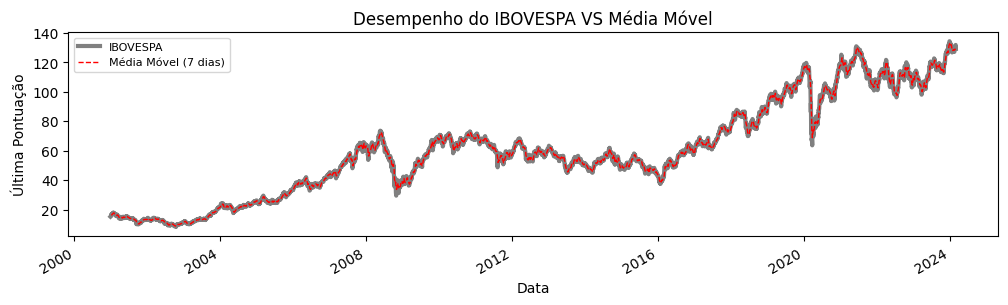

In [ ]:
# Calcula a média móvel com janela de 7 dias
df['Media_Movel'] = df['Último'].rolling(window=7).mean()

plt.figure(figsize=(12, 3))

# Plota os dados de abertura
plt.plot(df['Data'], df['Último'], label='IBOVESPA', color='grey', linewidth=3)

# Plota a linha de média móvel
plt.plot(df['Data'], df['Media_Movel'], label='Média Móvel (7 dias)', color='red', linestyle='--', linewidth=1)

# Adiciona título e rótulos dos eixos
plt.title('Desempenho do IBOVESPA VS Média Móvel', fontsize=12)
plt.xlabel('Data', fontsize=10)
plt.ylabel('Última Pontuação', fontsize=10)

# Adiciona uma legenda
plt.legend(fontsize=8)

# Ajusta a formatação da data no eixo x para melhor visualização
plt.gcf().autofmt_xdate()

# Exibe o gráfico
plt.show()


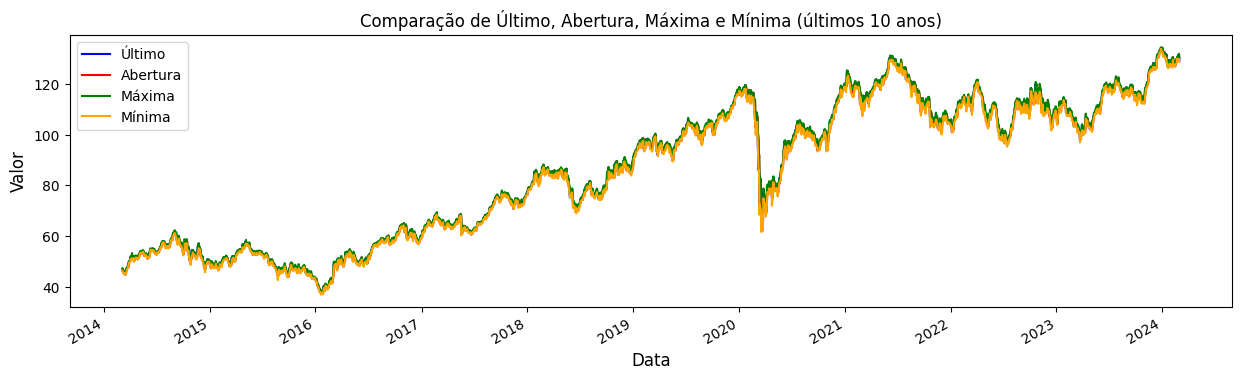

In [ ]:
# Converter a coluna 'Data' para o formato de data
df['Data'] = pd.to_datetime(df['Data'])

# Filtrar apenas os últimos 10 anos
data_atual = pd.to_datetime('today')
data_inicio = data_atual - pd.DateOffset(years=10)
df_ultimos_10_anos = df[df['Data'] >= data_inicio]

# Plotar o gráfico com os dados dos últimos 10 anos

plt.figure(figsize=(15, 4))

# Plota os dados de 'Último'
plt.plot(df_ultimos_10_anos['Data'], df_ultimos_10_anos['Último'], label='Último', color='blue')

# Plota os dados de 'Abertura'
plt.plot(df_ultimos_10_anos['Data'], df_ultimos_10_anos['Abertura'], label='Abertura', color='red')

# Plota os dados de 'Máxima'
plt.plot(df_ultimos_10_anos['Data'], df_ultimos_10_anos['Máxima'], label='Máxima', color='green')

# Plota os dados de 'Mínima'
plt.plot(df_ultimos_10_anos['Data'], df_ultimos_10_anos['Mínima'], label='Mínima', color='orange')

# Adiciona título e rótulos dos eixos
plt.title('Comparação de Último, Abertura, Máxima e Mínima (últimos 10 anos)', fontsize=12)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Valor', fontsize=12)

# Adiciona uma legenda
plt.legend(fontsize=10)

# Ajusta a formatação da data no eixo x para melhor visualização
plt.gcf().autofmt_xdate()

# Exibe o gráfico
plt.show()


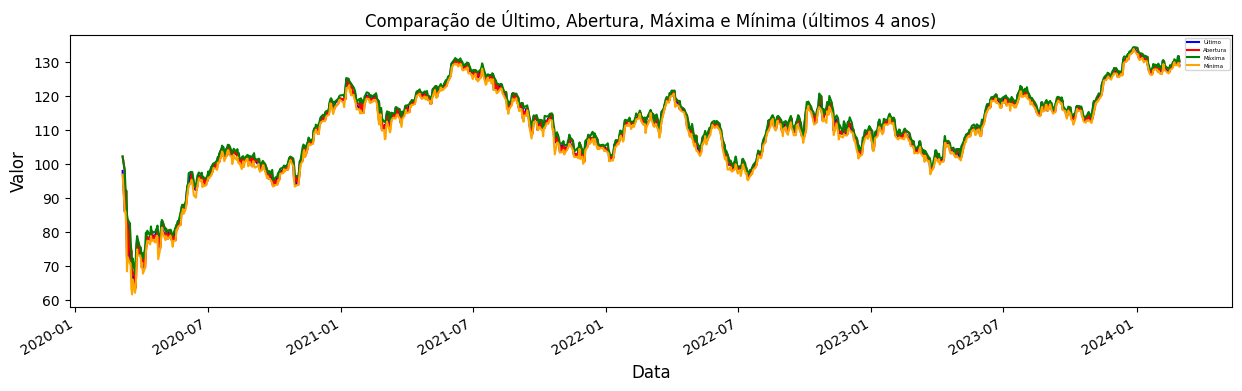

In [ ]:
# Filtrar apenas os últimos 4 anos
data_atual = pd.to_datetime('today')
data_inicio = data_atual - pd.DateOffset(years=4)
df_ultimos_4_anos = df[df['Data'] >= data_inicio]

# Plotar o gráfico com os dados dos últimos 4 anos
plt.figure(figsize=(15, 4))

# Plota os dados de 'Último'
plt.plot(df_ultimos_4_anos['Data'], df_ultimos_4_anos['Último'], label='Último', color='blue')

# Plota os dados de 'Abertura'
plt.plot(df_ultimos_4_anos['Data'], df_ultimos_4_anos['Abertura'], label='Abertura', color='red')

# Plota os dados de 'Máxima'
plt.plot(df_ultimos_4_anos['Data'], df_ultimos_4_anos['Máxima'], label='Máxima', color='green')

# Plota os dados de 'Mínima'
plt.plot(df_ultimos_4_anos['Data'], df_ultimos_4_anos['Mínima'], label='Mínima', color='orange')

# Adiciona título e rótulos dos eixos
plt.title('Comparação de Último, Abertura, Máxima e Mínima (últimos 4 anos)', fontsize=12)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Valor', fontsize=12)

# Adiciona uma legenda
plt.legend(fontsize=4)

# Ajusta a formatação da data no eixo x para melhor visualização
plt.gcf().autofmt_xdate()

# Exibe o gráfico
plt.show()

# **DECOMPOSIÇÃO DA SÉRIE**

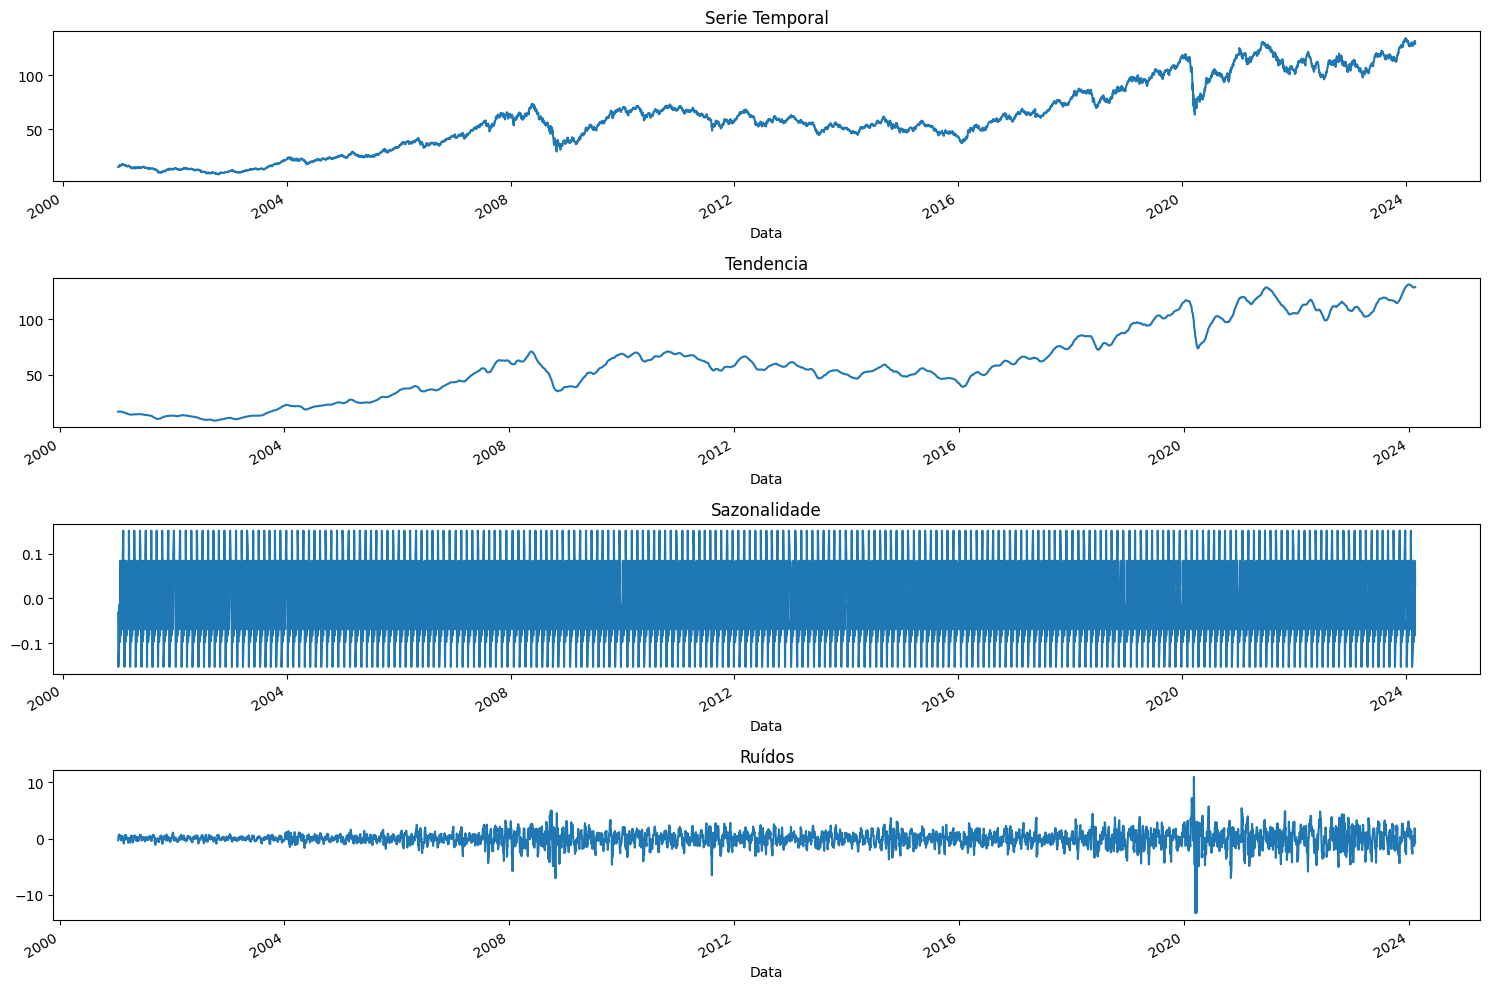

In [ ]:
# Cópia do dataframe
df_essentials = df.copy()

# Removendo colunas desnecessárias
df_essentials = df_essentials.drop(columns=['Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%', 'Media_Movel'])

# Convertendo a coluna 'Data' para o índice do DataFrame
df_essentials['Data'] = pd.to_datetime(df_essentials['Data'])
df_essentials.set_index('Data', inplace=True)

# Aplicando a decomposição sazonal
result = seasonal_decompose(df_essentials, period=25)

# Plotando os componentes da decomposição
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
result.observed.plot(ax=ax1, title='Serie Temporal')
result.trend.plot(ax=ax2, title='Tendencia')
result.seasonal.plot(ax=ax3, title='Sazonalidade')
result.resid.plot(ax=ax4, title='Ruídos')

plt.tight_layout()
plt.show()


# **MEDIA MOVEL**

In [ ]:
#CONFERINDO O DATASET ESSENCIAL
df_essentials.head()

,Último
Data,
2000-12-27,15.186
2000-12-28,15.259
2001-01-02,15.425
2001-01-03,16.599
2001-01-04,16.675


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#DEFININDO PARAMETROS DAS MÉDIAS
##windows_size = 3
df_essentials['MA_5'] = df_essentials['Último'].rolling(5).mean().shift()
df_essentials['MA_10'] = df_essentials['Último'].rolling(10).mean().shift()
df_essentials['MA_15'] = df_essentials['Último'].rolling(15).mean().shift()
df_essentials['MA_30'] = df_essentials['Último'].rolling(30).mean().shift()
df_essentials.head(50)

df_essentials.dropna(inplace=True)

#ERRO QUADRÁTICO (MSE)
mse1 = mean_squared_error(df_essentials['Último'], df_essentials['MA_5'])
mse2 = mean_squared_error(df_essentials['Último'], df_essentials['MA_10'])
mse3 = mean_squared_error(df_essentials['Último'], df_essentials['MA_15'])
mse4 = mean_squared_error(df_essentials['Último'], df_essentials['MA_30'])


#R²
r2_ma5 = r2_score(df_essentials['Último'], df_essentials['MA_5'])
r2_ma10 = r2_score(df_essentials['Último'], df_essentials['MA_10'])
r2_ma15 = r2_score(df_essentials['Último'], df_essentials['MA_15'])
r2_ma30 = r2_score(df_essentials['Último'], df_essentials['MA_30'])


#TRANSFORMANDO EM %
assertividade_ma5 = r2_ma5 * 100
assertividade_ma10 = r2_ma10 * 100
assertividade_ma15 = r2_ma15 * 100
assertividade_ma30 = r2_ma30 * 100

#IMPRIMINDO RESULTADO
print(f"MA5 {assertividade_ma5}")
print(f"MA10 {assertividade_ma10}")
print(f"MA15 {assertividade_ma15}")
print(f"MA30 {assertividade_ma30}")

MA5 99.73738670489526
MA10 99.54417098241281
MA15 99.325390840384
MA30 98.62662352604144


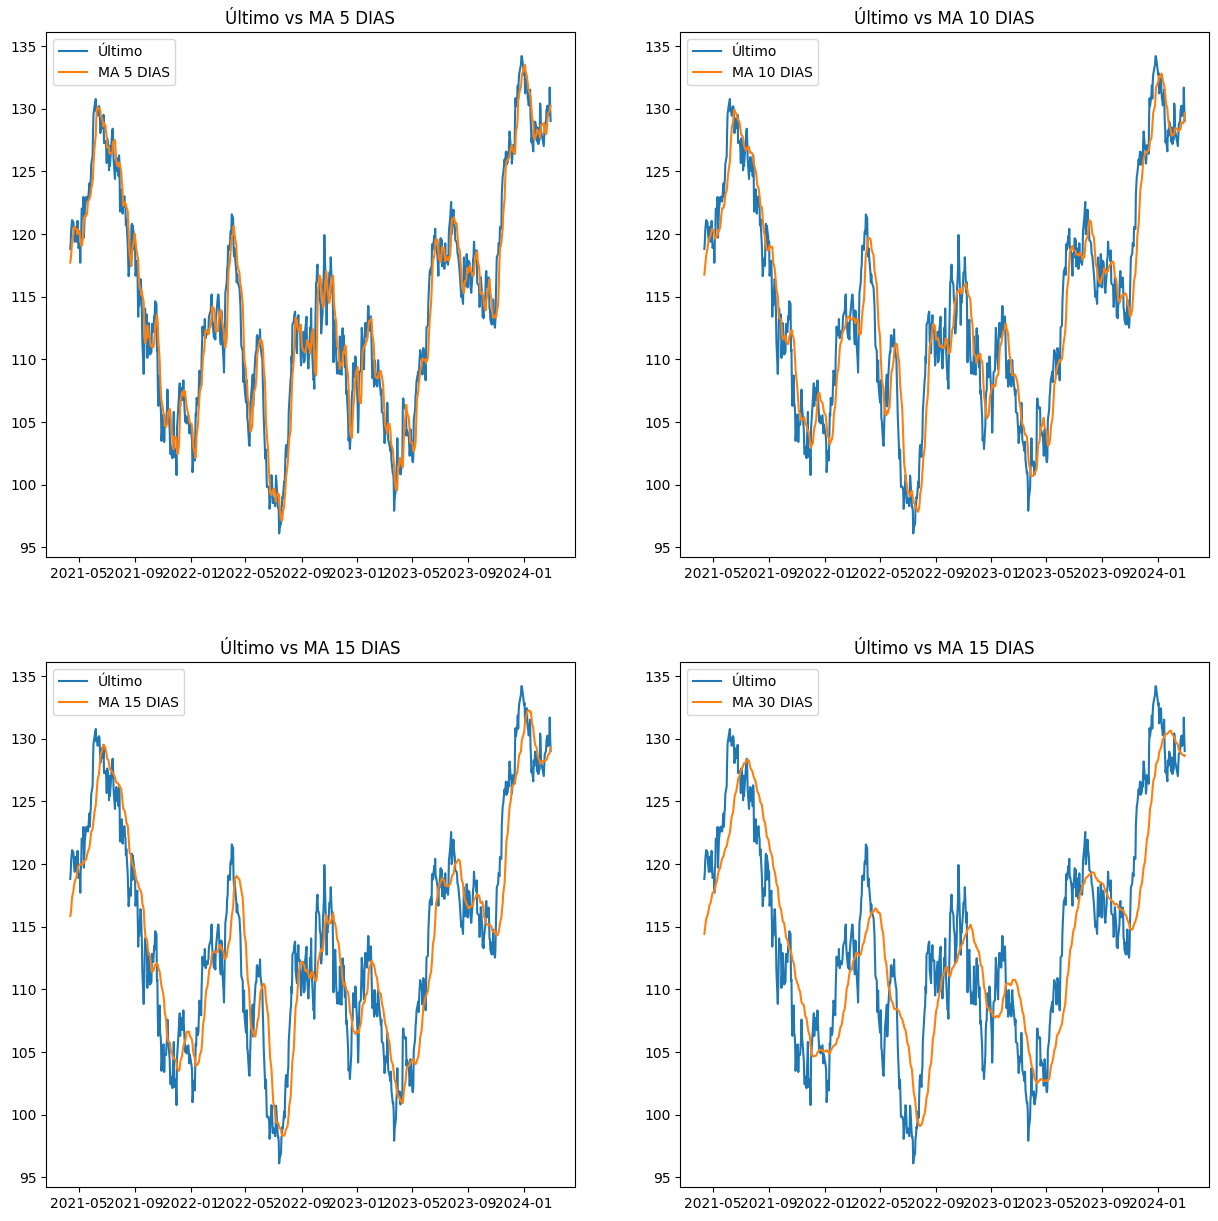

In [ ]:
limit = 720
plt.figure(figsize=(15, 15))

# MA5
plt.subplot(2, 2, 1)
plt.plot(df_essentials['Último'][-limit:], label='Último')
plt.plot(df_essentials['MA_5'][-limit:], label='MA 5 DIAS')
plt.legend(loc=2)
plt.title('Último vs MA 5 DIAS')

# MA10
plt.subplot(2, 2, 2)
plt.plot(df_essentials['Último'][-limit:], label='Último')
plt.plot(df_essentials['MA_10'][-limit:], label='MA 10 DIAS')
plt.legend(loc=2)
plt.title('Último vs MA 10 DIAS')

# MA15
plt.subplot(2, 2, 3)
plt.plot(df_essentials['Último'][-limit:], label='Último')
plt.plot(df_essentials['MA_15'][-limit:], label='MA 15 DIAS')
plt.legend(loc=2)
plt.title('Último vs MA 15 DIAS')

# MA30
plt.subplot(2, 2, 4)
plt.plot(df_essentials['Último'][-limit:], label='Último')
plt.plot(df_essentials['MA_30'][-limit:], label='MA 30 DIAS')
plt.legend(loc=2)
plt.title('Último vs MA 15 DIAS')

plt.show()


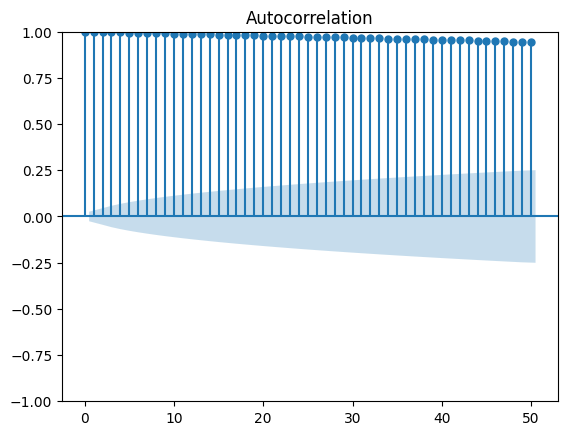

In [ ]:
sm.graphics.tsa.plot_acf(df_essentials, lags=50)
plt.show()

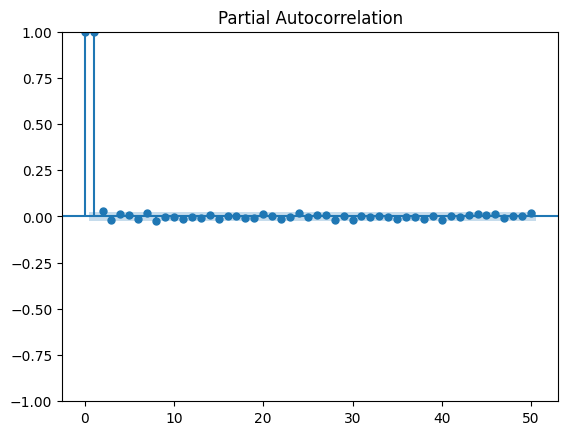

In [ ]:
sm.graphics.tsa.plot_pacf(df_essentials, lags=50)

plt.show()

In [ ]:
df.groupby("produto")